# VeronaCard Next‑POI Prediction – Metrics & Exploratory Analysis

*Generated automatically on 2025-06-25 13:01 UTC*


**Objectives**

1. Load all prediction CSV files produced by `veronacard_mob.py` (`*_pred_*.csv`).
2. Compute evaluation metrics  
   - Top‑1 Accuracy  
   - Top‑5 Hit Rate  
   - Mean Reciprocal Rank (MRR)  
   - Catalogue Coverage  
3. Visualise the metrics globally and per calendar year (2016 → 2020).
4. Provide an extendable framework for further error analysis (confusion matrices, cluster quality, temporal patterns).

> **Nota bene** – questo notebook non assume directory hard‑coded: basta mettere i CSV nella stessa cartella del notebook o impostare `DATA_DIR` opportunamente.


In [34]:

from pathlib import Path
import ast
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.grid'] = True


## 1. Load data

In [35]:
from pathlib import Path
import glob, ast, os
import numpy as np
import pandas as pd

# Percorso ai file CSV
csv_files = [Path(p) for p in glob.glob(os.path.join('results', '*_pred_*.csv'))]
csv_files = sorted(csv_files)
assert csv_files, "No CSV files matching *_pred_*.csv found!"

dfs = []
for fp in csv_files:
    df = pd.read_csv(fp)

    # Estrai l'anno dal nome file, es. dati_2016_pred_...
    year_token = next((part for part in fp.stem.split('_')
                       if part.isdigit() and len(part) == 4), None)
    df['year'] = int(year_token) if year_token else np.nan

    df['prediction_list'] = df['prediction'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else []
    )
    df = df[df['prediction_list'].apply(len) == 5]
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
print(f"Loaded {len(df_all):,} rows from {len(csv_files)} files")
df_all.head()


Loaded 743,594 rows from 14 files


,card_id,cluster,history,current_poi,prediction,ground_truth,reason,hit,year,prediction_list
0,040000523F3885,1,"['Tomba Giulietta', 'Castelvecchio', 'San Ferm...",Duomo,"['Torre dei Lamberti', 'Archeologico', 'Ponte ...",Arena,"Come assistente turistico, ho valutato la stor...",False,2014,"[Torre dei Lamberti, Archeologico, Ponte Pietr..."
1,040001523F3885,0,"['San Fermo', 'Santa Anastasia', 'Teatro Roman...",Arena,"['Castelvecchio', 'Giardino Giusti Lazzerini',...",Castelvecchio,Considerando la zona dell'Arena e gli altri lu...,True,2014,"[Castelvecchio, Giardino Giusti Lazzerini, Cas..."
2,0400018ABF3185,6,"['Arena', 'Tomba Giulietta', 'Torre Lamberti',...",Duomo,"['Castel San Pietro', 'Basilica di San Zeno', ...",Castelvecchio,"Considerando la posizione attuale del Duomo, s...",False,2014,"[Castel San Pietro, Basilica di San Zeno, Pont..."
3,040002523F3885,0,"['San Fermo', 'Santa Anastasia', 'Teatro Roman...",Arena,"['Giardino Giusti', 'Castel San Pietro', 'Torr...",Castelvecchio,I POI selezionati sono strategicamente ubicati...,False,2014,"[Giardino Giusti, Castel San Pietro, Torre dei..."
4,040003523F3885,2,"['San Fermo', 'Arena', 'Casa Giulietta', 'Teat...",Tomba Giulietta,"['Ponte Pietra', 'Torre dei Lamberti', 'Giardi...",San Zeno,Questi luoghi sono situati nel cuore storico d...,False,2014,"[Ponte Pietra, Torre dei Lamberti, Giardino Bo..."



## 2. Metric definitions

Given the true next POI \(y_i\) and an **ordered** recommendation list
\(\hat{y}_i^{(1)},\hat{y}_i^{(2)},\dots,\hat{y}_i^{(k)}\):

- **Top‑1 Accuracy**

\[
\text{Acc}_{@1}=\frac{1}{N}\sum_{i=1}^{N}\mathbb{1}\{y_i=\hat{y}_i^{(1)}\}
\]

- **Top‑\(k\) Hit Rate**

\[
\text{HR}_{@k}=\frac{1}{N}\sum_{i=1}^{N}\mathbb{1}\{y_i \in
\{\hat{y}_i^{(1)},\dots,\hat{y}_i^{(k)}\}\}
\]

- **Mean Reciprocal Rank (MRR)**

\[
\text{MRR}=\frac{1}{N}\sum_{i=1}^{N}\frac{1}{\operatorname{rank}_i}\;,
\quad\operatorname{rank}_i = \min\{ r\mid y_i=\hat{y}_i^{(r)}\}
\]

- **Catalogue Coverage**

\[
\text{Coverage}=\frac{|\bigcup_{i}\{\hat{y}_i^{(1)},\dots,\hat{y}_i^{(k)}\}|}
                      {|\mathcal{P}|}
\]
where \(\mathcal{P}\) is the full set of Points of Interest present in ground‑truth.


### 2.1 Helper functions & per‑row computations

In [36]:
import json

def poi_id(x):
    """
    Converte 'x' in un identificatore hashable comparabile con ground-truth.
    • Se x è un dict          → prova a usare 'poi', 'poi_id', 'name', 'id'
    • Se x è list/tuple       → ritorna tupla ricorsiva
    • Altrimenti (str/int)    → cast a str
    """
    if isinstance(x, dict):
        for key in ('poi', 'poi_id', 'name', 'id'):
            if key in x:
                return str(x[key])
        # fallback: serializza in JSON ordinato
        return json.dumps(x, sort_keys=True)
    elif isinstance(x, (list, tuple)):
        return tuple(map(poi_id, x))
    else:
        return str(x)

# Normalizza prediction_list e ground_truth
df_all['prediction_norm']    = df_all['prediction_list'].apply(lambda lst: [poi_id(e) for e in lst])
df_all['ground_truth_norm']  = df_all['ground_truth'].apply(poi_id)

# -- metriche element-wise --------------------------------------------
df_all['hit@1'] = df_all['prediction_norm'].str[0] == df_all['ground_truth_norm']

def top_k_hit(row, k=5):
    return row['ground_truth_norm'] in row['prediction_norm'][:k]

def reciprocal_rank(row, k=5):
    try:
        rank = row['prediction_norm'][:k].index(row['ground_truth_norm']) + 1
        return 1.0 / rank
    except ValueError:
        return 0.0

df_all['hit@5'] = df_all.apply(top_k_hit, axis=1)
df_all['rr']    = df_all.apply(reciprocal_rank, axis=1)

### 2.2 Global metrics

In [37]:
metrics_global = {
    "Top-1 Accuracy": df_all["hit@1"].mean(),
    "Top-5 Hit Rate": df_all["hit@5"].mean(),
    "MRR": df_all["rr"].mean(),
}

# Catalogue Coverage
coverage_set = {poi for preds in df_all["prediction_norm"] for poi in preds}
metrics_global["Catalogue Coverage"] = (
    len(coverage_set) / df_all["ground_truth_norm"].nunique()
)

# Visualizza in percentuale
metrics_df = (
    pd.DataFrame(metrics_global, index=["Value"])
      .T
      .style.format("{:.2%}")
)
display(metrics_df)

,Value
Top-1 Accuracy,10.04%
Top-5 Hit Rate,16.25%
MRR,12.58%
Catalogue Coverage,131163.64%


### 2.3 Metrics by year

In [38]:

by_year = (
    df_all
    .groupby('year')
    .agg(
        top1=('hit@1', 'mean'),
        hit5=('hit@5', 'mean'),
        mrr=('rr', 'mean'),
        n=('card_id', 'size')
    )
    .reset_index()
    .sort_values('year')
)
display(by_year)


,year,top1,hit5,mrr,n
0,2014,0.098495,0.165234,0.125796,129743
1,2015,0.102379,0.168900,0.129502,131267
2,2016,0.099952,0.165821,0.127011,69153
3,2017,0.094066,0.160575,0.121172,80050
4,2018,0.092648,0.156137,0.118812,77163
5,2019,0.108586,0.167686,0.132444,139254
6,2020,0.109563,0.178938,0.137636,13636
7,2021,0.089511,0.136009,0.108364,21528
8,2022,0.101995,0.147665,0.121323,71337
9,2023,0.101501,0.155309,0.123585,10463


## 3. Visualisations

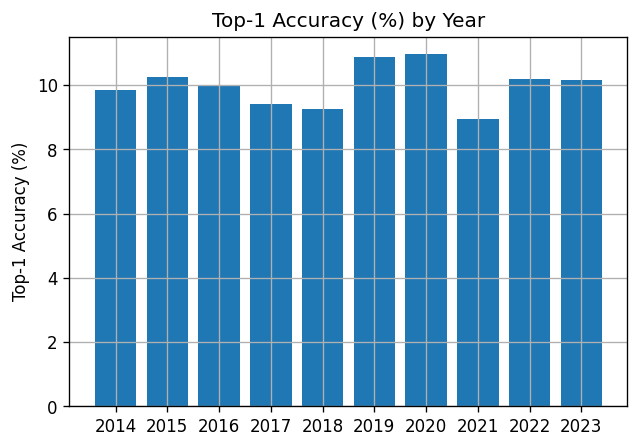

In [39]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(by_year['year'].astype(str), by_year['top1']*100)
ax.set_ylabel('Top‑1 Accuracy (%)')
ax.set_title('Top‑1 Accuracy (%) by Year')
plt.show()


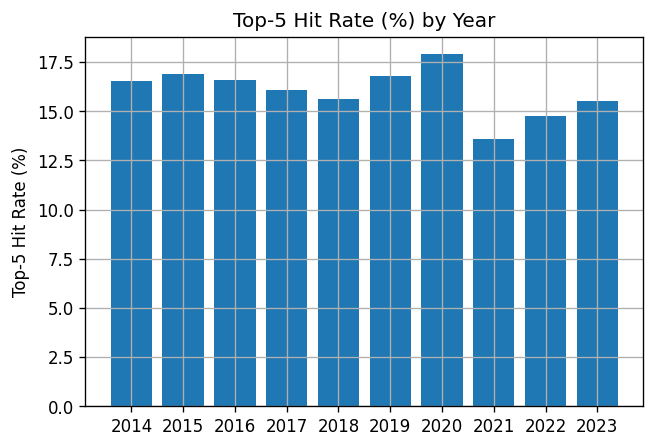

In [40]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(by_year['year'].astype(str), by_year['hit5']*100)
ax.set_ylabel('Top‑5 Hit Rate (%)')
ax.set_title('Top‑5 Hit Rate (%) by Year')
plt.show()


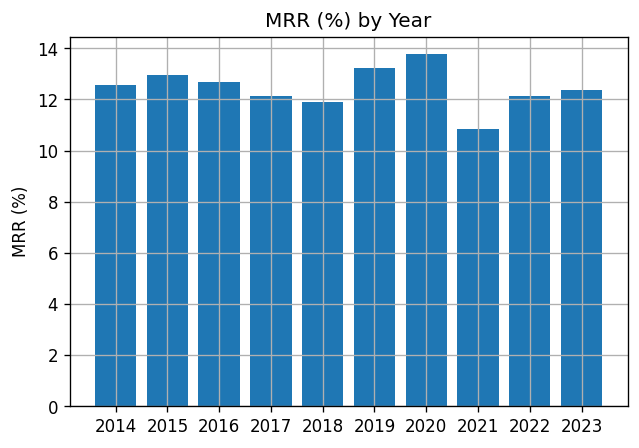

In [41]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(by_year['year'].astype(str), by_year['mrr']*100)
ax.set_ylabel('MRR (%)')
ax.set_title('MRR (%) by Year')
plt.show()


### 3.1 Coverage breakdown

In [42]:
unique_pred_poi = (
    pd.Series([poi for preds in df_all["prediction_norm"] for poi in preds])
      .nunique()
)
unique_gt_poi = df_all["ground_truth_norm"].nunique()

print(f"POI distinct in predictions: {unique_pred_poi}")
print(f"POI distinct in ground-truth: {unique_gt_poi}")
print(f"Catalogue Coverage: {unique_pred_poi/unique_gt_poi:.2%}")

POI distinct in predictions: 28856
POI distinct in ground-truth: 22
Catalogue Coverage: 131163.64%


## 4. Error analysis – overview

In questa sezione valutiamo **dove** e **perché** il modello sbaglia, seguendo tre filoni:

1. **Worst-performing POI pairs**  
   Scopriamo quali coppie `ground-truth → first_pred` generano il maggior numero di errori.

2. **Confusion matrix per subset**  
   Heat-map delle frequenze (o tasso d’errore) su un sotto-insieme di POI di interesse
   (ad es. i 20 più visitati o solo l’anno 2020).

3. **Explainability (SHAP / LIME)**  
   Analisi dei fattori testuali nella colonna `history` che portano a una predizione
   sbagliata. Qui mostriamo un prototipo basato su LIME; lo script è modulare
   e può essere sostituito da SHAP se usi modelli compatibili.


,ground_truth_norm,first_pred,errors
1539,Castelvecchio,Ponte Pietra,31150
1908,Duomo,Castelvecchio,25163
7046,Torre Lamberti,Ponte Pietra,24888
6475,Tomba Giulietta,Ponte Pietra,22043
5200,Santa Anastasia,Ponte Pietra,20963
5804,Teatro Romano,Ponte Pietra,20573
2301,Duomo,Ponte Pietra,19639
947,Casa Giulietta,Ponte Pietra,19199
668,Casa Giulietta,Castelvecchio,18593
5430,Teatro Romano,Castelvecchio,18482


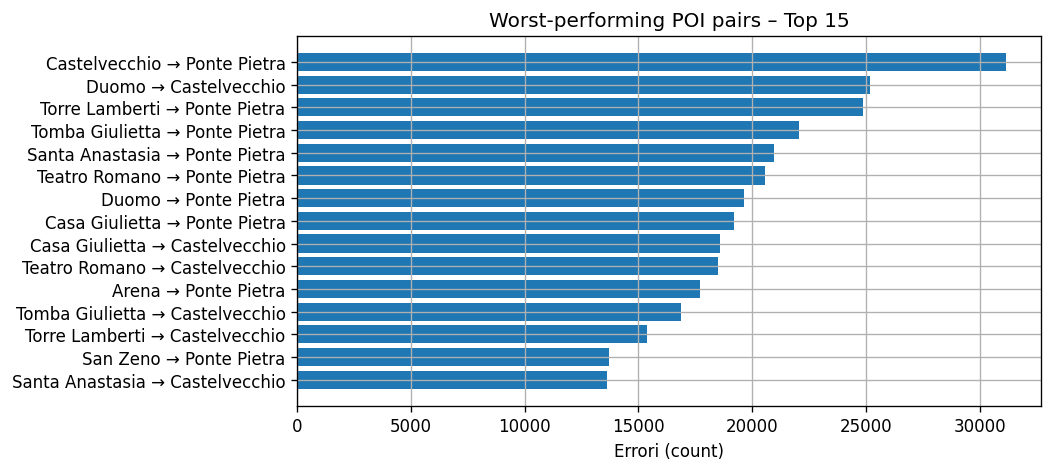

In [43]:
# ---------------------------------------------------------------------
# 4.1 Worst-performing POI pairs (Top-N) – FIX
# ---------------------------------------------------------------------
# filtro righe con errore Top-1
ERR = df_all.assign(first_pred=df_all["prediction_norm"].str[0])
ERR = ERR[~ERR["hit@1"]]           # equivalente a query("`hit@1` == False")

# conteggia coppie ground-truth → first_pred
pairs = (
    ERR.groupby(["ground_truth_norm", "first_pred"])
        .size()
        .reset_index(name="errors")
        .sort_values("errors", ascending=False)
        .head(15)          # Top-15 coppie
)

display(pairs)

# barplot (opzionale)
fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(
    pairs.apply(lambda r: f"{r['ground_truth_norm']} → {r['first_pred']}", axis=1),
    pairs["errors"]
)
ax.set_xlabel("Errori (count)")
ax.set_title("Worst-performing POI pairs – Top 15")
ax.invert_yaxis()
plt.show()


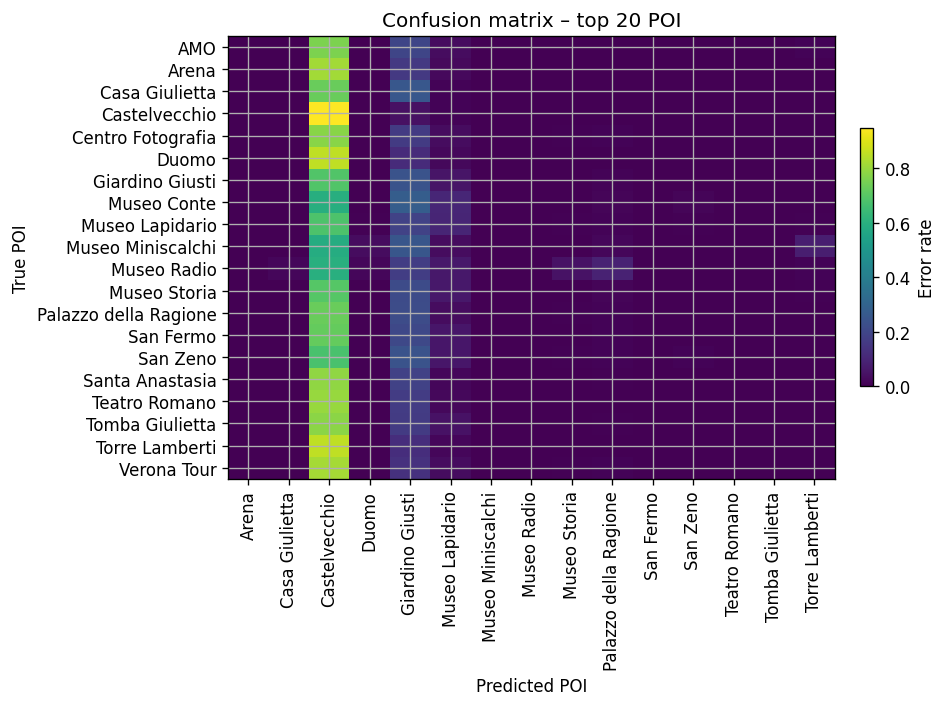

In [44]:
# ---------------------------------------------------------------------
# 4.2 Confusion matrix – seleziona subset
# ---------------------------------------------------------------------
TOP_K = 20          # limitiamoci ai 20 POI più frequenti (ground-truth)
YEAR  = None        # imposta un anno (es. 2020) oppure None per all

subset = df_all.copy()
if YEAR is not None:
    subset = subset.query("year == @YEAR")

# filtra i POI più frequenti
top_poi = (
    subset["ground_truth_norm"]
           .value_counts()
           .head(TOP_K)
           .index
)
mask = subset["ground_truth_norm"].isin(top_poi) & subset["prediction_norm"].str[0].isin(top_poi)
cm_df = pd.crosstab(
    subset.loc[mask, "ground_truth_norm"],
    subset.loc[mask, "prediction_norm"].str[0],
    rownames=["True"],
    colnames=["Pred"],
    dropna=False
)

# Normalizza su righe per avere tassi d’errore
cm_norm = cm_df.div(cm_df.sum(axis=1), axis=0)

# Heat-map (matplotlib only)
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(cm_norm.values, aspect="auto")
ax.set_xticks(range(len(cm_norm.columns)))
ax.set_xticklabels(cm_norm.columns, rotation=90)
ax.set_yticks(range(len(cm_norm.index)))
ax.set_yticklabels(cm_norm.index)
ax.set_xlabel("Predicted POI")
ax.set_ylabel("True POI")
ax.set_title(f"Confusion matrix – top {TOP_K} POI" + (f", year {YEAR}" if YEAR else ""))
fig.colorbar(im, ax=ax, fraction=0.02, pad=0.04, label="Error rate")
plt.tight_layout()
plt.show()


In [47]:
# ---------------------------------------------------------------------
# 4.3 Explainability – LIME Text (robust version)
# ---------------------------------------------------------------------
import warnings, json, numpy as np, pandas as pd
from tqdm.auto import tqdm

# ╭───────────────────────────────────────────────────────────────────╮
# | 1) Import & graceful-degradation                                 |
# ╰───────────────────────────────────────────────────────────────────╯
try:
    from lime.lime_text import LimeTextExplainer
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.linear_model import LogisticRegression
except ModuleNotFoundError:
    warnings.warn(
        "🛑  Il pacchetto 'lime' o 'scikit-learn' non è installato.\n"
        "    Esegui `!pip install lime scikit-learn` e riesegui la cella."
    )
    raise  # interrompe l’esecuzione solo di questa cella

# ╭───────────────────────────────────────────────────────────────────╮
# | 2) Prepara training set (history → first_pred)                    |
# ╰───────────────────────────────────────────────────────────────────╯
X_text = df_all["history"].astype(str).values
y_label = np.array([str(lbl) for lbl in df_all["prediction_norm"].str[0].values])  # cast a str

SAMPLE = 5_000
rng = np.random.default_rng(42)
idx = rng.choice(len(X_text), size=min(SAMPLE, len(X_text)), replace=False)

# TF-IDF senza stop-word italiane (sklearn ≥1.2 non le include)
vec = TfidfVectorizer(max_features=10_000, ngram_range=(1, 2), stop_words=None)
X_tf = vec.fit_transform(X_text[idx])

clf = LogisticRegression(max_iter=1_000, n_jobs=1).fit(X_tf, y_label[idx])
print(f"Training accuracy (proxy) on sampled set: {clf.score(X_tf, y_label[idx]):.2%}")

# ╭───────────────────────────────────────────────────────────────────╮
# | 3) Instanzia LIME ed estrai un caso d’errore                      |
# ╰───────────────────────────────────────────────────────────────────╯
explainer = LimeTextExplainer(class_names=np.unique(y_label).tolist())

err_rows = df_all[~df_all["hit@1"]]
if err_rows.empty:
    print("🎉  Nessun errore Top-1 da spiegare!")
else:
    err_idx = err_rows.index[0]           # primo errore disponibile
    sample_text = df_all.at[err_idx, "history"]
    pred_poi     = df_all.at[err_idx, "prediction_norm"][0]
    true_poi     = df_all.at[err_idx, "ground_truth_norm"]

    explanation = explainer.explain_instance(
        sample_text,
        lambda txt: clf.predict_proba(vec.transform(txt)),
        num_features=10,
        labels=[clf.classes_.tolist().index(pred_poi)],
    )

    # ╭───────────────────────────────────────────────────────────────╮
    # | 4) Rendering con fallback testuale                            |
    # ╰───────────────────────────────────────────────────────────────╯
    print("History  :", sample_text[:300].replace("\n", " ") + (" …" if len(sample_text) > 300 else ""))
    print("True POI :", true_poi)
    print("Pred POI :", pred_poi)
    print("─"*60)

    try:
        from IPython.display import display, HTML
        display(HTML(explanation.as_html()))
    except Exception as e:  # IPython mancante o frontend non grafico
        warnings.warn(f"Rendering HTML fallito: {e}\nStampa fallback testuale.")
        for feat, weight in explanation.as_list():
            print(f"{feat:>25s} | {weight:+.3f}")


Training accuracy (proxy) on sampled set: 43.14%
History  : ['Tomba Giulietta', 'Castelvecchio', 'San Fermo', 'Casa Giulietta', 'Santa Anastasia']
True POI : Arena
Pred POI : Torre dei Lamberti
────────────────────────────────────────────────────────────
